# LukFPV


## We start by loading all the necessary modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
from os import fspath
import seaborn as sns
import pandas as pd
import math
import time
import nglview
import pickle
import MDAnalysis as mda
import plotly.express as px # interactive plots
plt.rcParams['figure.dpi']= 200 # better resolution

In [2]:
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis.analysis.rms import RMSD, rmsd
from MDAnalysis.analysis.rms import RMSF
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from MDAnalysis.analysis.pca import PCA, cosine_content
from MDAnalysis.analysis.distances import distance_array
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from MDAnalysis.analysis.dihedrals import Ramachandran
from MDAnalysis.coordinates.XTC import XTCReader

### Setup the path for all input/output data

Once we save them in a different directory we will take them with LaTex

#### Input

In [3]:
setup_path = Path('../data/extended_production/')
GRO = setup_path / 'step7_1.gro'
XTC = setup_path /'step7_1_nojump.xtc'

#### Output

In [4]:
imgs_path = setup_path
files_path = setup_path

# Define just a dumb import function:

In [5]:
def _XVG_(path):

    x, y = [], []

    with open(path) as f:
        for line in f:
            cols = line.split()

            if len(cols) == 2:
                x.append(float(cols[0]))
                y.append(float(cols[1]))
    return x,y

# Density plot

## RMSD:

We will do the RMSD in many different ways. 

In [12]:
conv = 340/6822 #conversion between frames and ns

In [13]:
u = mda.Universe(str(GRO), str(XTC))
ref = mda.Universe(str(GRO), str(XTC))
ref.trajectory[0] # we count everything in respect to the first frame
ref.trajectory.n_frames # we expect all the 6001 frames we have

6822

In [14]:
rmsd(u.select_atoms('name CA').positions, ref.select_atoms('name CA').positions) # do that on CA

0.0

In [16]:
rmsd_arr = [rmsd(u.select_atoms('name CA').positions, ref.select_atoms('name CA').positions, center=True, superposition=True) for ts in u.trajectory[:]]

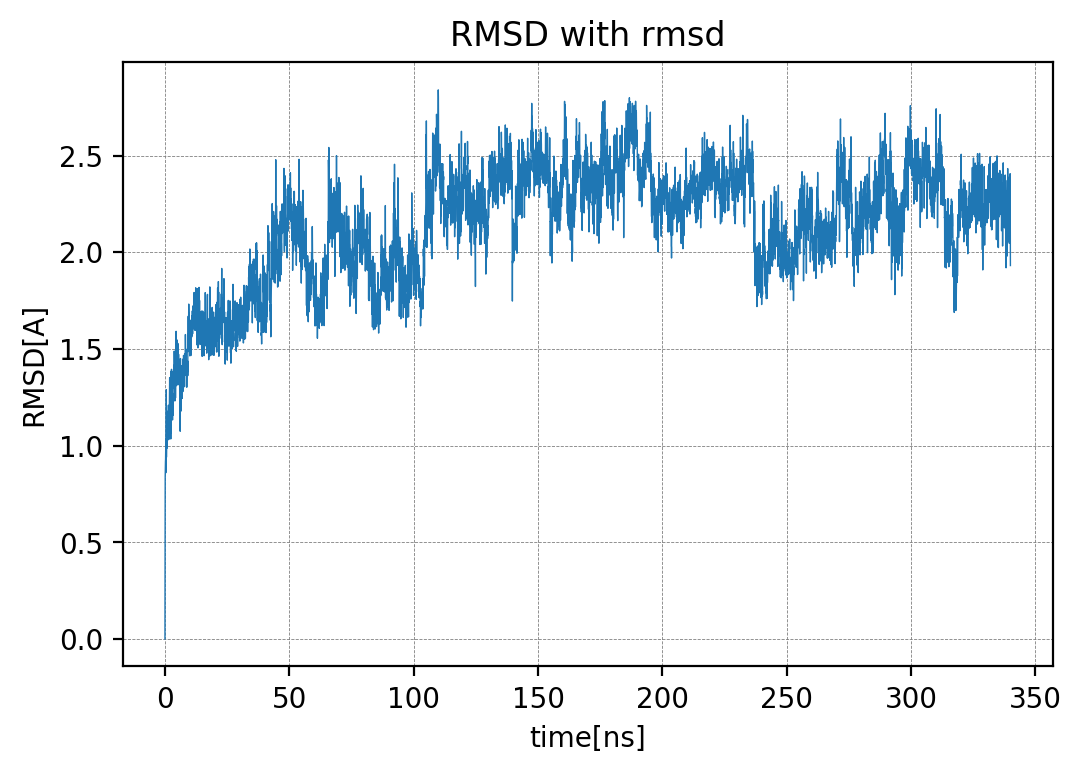

In [17]:
rmsdd = np.array(rmsd_arr)
time = [x*conv for x in range(len(rmsdd))] #In this way we keep only the divisors

plt.plot(time,rmsdd,linewidth=0.5)
plt.xlabel('time[ns]')
plt.ylabel('RMSD[A]')
plt.title('RMSD with rmsd')
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.savefig(imgs_path / 'RMSD.png')

## RMSD pandas

In this part we will evaluate another time the RMSD by using a pandas dataframe

In [18]:
sel = 'name CA'
group = ['idx','time', 'CA','backbone','resid 20:50']

In [19]:
u_pd = mda.Universe(str(GRO), str(XTC))
u_pd_ref = mda.Universe(str(GRO), str(XTC))
u_pd_ref.trajectory[0]

< Timestep 0 with unit cell dimensions [ 94.164   94.164  152.9832  90.      90.      90.    ] >

In [20]:
R_pd = RMSD(u_pd, u_pd_ref, select=sel, groupselections=['backbone', 'resid 20:50 and name CA']).run()

In [21]:
rmsd_pd =  pd.DataFrame(R_pd.rmsd,columns=group)
rmsd_pd

idx      time        CA  backbone  resid 20:50
0        0.0       0.0  0.000000  0.000000     0.000000
1        1.0      50.0  0.623737  0.634181     0.508756
2        2.0     100.0  0.840956  0.852461     0.553256
3        3.0     150.0  0.897962  0.914141     0.565809
4        4.0     200.0  0.916916  0.943316     0.641655
...      ...       ...       ...       ...          ...
6817  6817.0  340850.0  2.083901  2.049513     1.019119
6818  6818.0  340900.0  2.305878  2.256766     1.471832
6819  6819.0  340950.0  2.406273  2.367424     1.647935
6820  6820.0  341000.0  2.142584  2.087124     1.085764
6821  6821.0  341050.0  1.931402  1.891011     1.046540

[6822 rows x 5 columns]

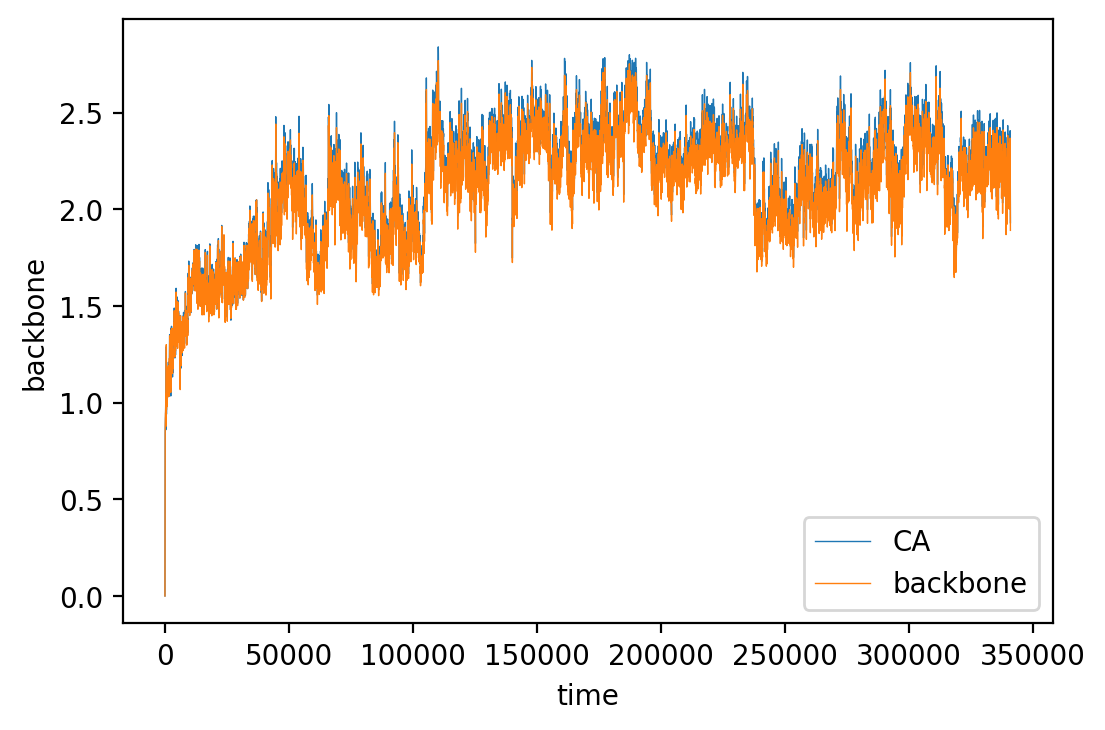

In [22]:
ax = sns.lineplot(data=rmsd_pd,x='time',y='CA', label='CA',linewidth=0.5)
ax = sns.lineplot(data=rmsd_pd,x='time',y='backbone',ax=ax, label='backbone',linewidth=0.5)

## RMSD AlignTraj

We can also use the AlignTraj function which should give the same results as before

In [23]:
u_AT = mda.Universe(str(GRO), str(XTC))
u_AT_ref = mda.Universe(str(GRO), str(XTC))
u_AT_ref.trajectory[0]

< Timestep 0 with unit cell dimensions [ 94.164   94.164  152.9832  90.      90.      90.    ] >

In [24]:
aligner = AlignTraj(u_AT, u_AT_ref, select='name CA', filename='../report/files/protein_aligned.dcd')

In [25]:
# It is kinda heavy, since it is creating a file of 3Gb c.a. --> this is already present in our folder (in the
# path elencated in the command above, so don't run it!)
aligner.run()

In [27]:
rec_alignd = mda.Universe(str(GRO),str('../report/files/protein_aligned.dcd'))
rmsd_arr_AT = [rmsd(rec_alignd.select_atoms("name CA").positions, u_AT_ref.select_atoms("name CA").positions) for ts in rec_alignd.trajectory] 

In [ ]:
plt.plot(time,np.array(rmsd_arr_AT),linewidth=0.5)
plt.plot(time,rmsd_pd.CA.values,linewidth=0.5) 
plt.plot(time,aligner.rmsd,linewidth=0.5)  
plt.xlabel('time[ns]')
plt.ylabel('RMSD[A]')
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.title('RMSD with AlignTraj vs pandas')
plt.legend(['AlignTraj', 'Pandas','Difference'])
plt.savefig ( imgs_path / 'Rmsd_Difference.png')

## RMSF:

The RMSF highlights the activity of each site, if evaluated correctly we should have something in accord with the experimental beta factor. We start by computing it through the MdAnalysis tool

### MDAnalysis

The fact that we are not able to properly run the aligner causes our impossibility to evaluate properly it though the RMSF function

In [28]:
ca_atoms = rec_alignd.select_atoms("protein and name CA") # this is the AtomGroup
myRMSF = RMSF(ca_atoms).run()

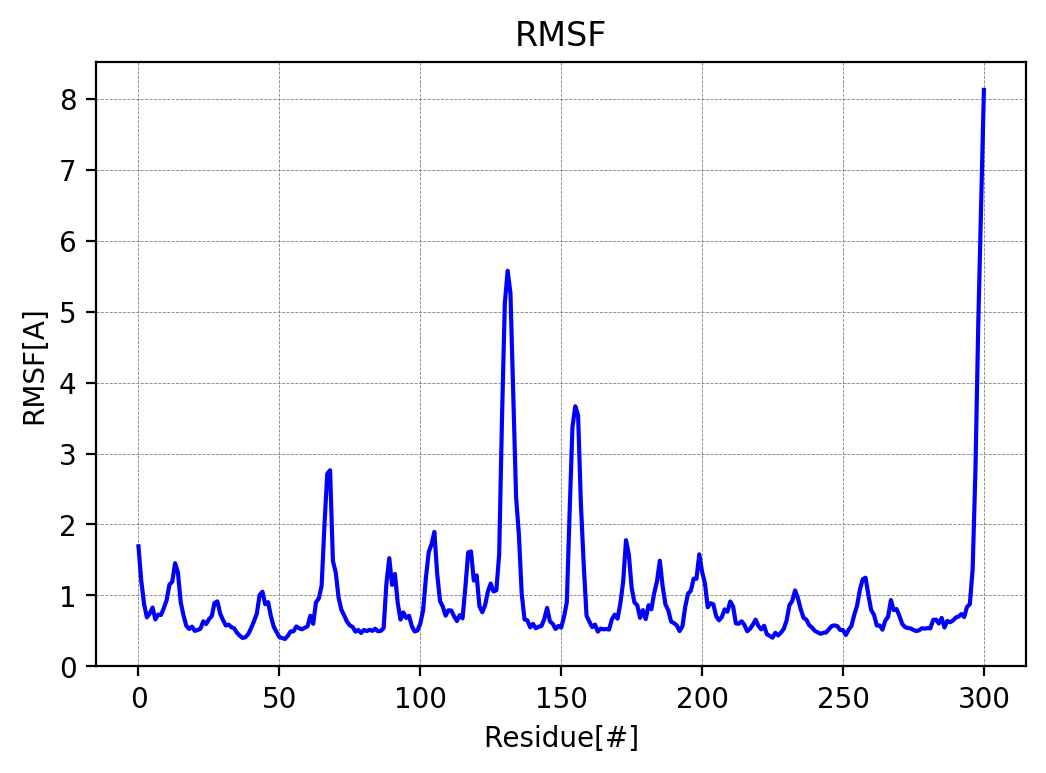

In [29]:
fig = plt.plot(myRMSF.rmsf,color="blue",linewidth=1.5)
plt.xlabel('Residue[#]')
plt.ylabel('RMSF[A]')
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.title('RMSF')
plt.savefig(imgs_path / 'RMSF.png')

### From Data:

Since we can evaluate it by using the gromacs built in tool we import the .xvg file and load it in python.
Then, we use the .pdb data to compare it with the experimentally found values

In [ ]:
PDB = '../data/00_starting_material/LukFPV_1pvl.pdb'
pdb_universe = mda.Universe(str(PDB))
ca_atoms_pdb = pdb_universe.select_atoms("protein and name CA")
betas = pdb_universe._topology.tempfactors.values[ca_atoms_pdb._ix]
betas_2 = np.sqrt(3/(8*math.pi) * (np.array(betas)))

In [ ]:
fig = plt.plot(betas,color="red",linewidth=1.5)
plt.xlabel('Residue[#]')
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.ylabel('$\\beta$')
plt.title('Experimental Beta factor')

### We try to make a comparison between the experimental RMSF and our results

 $$ BETA = \frac{8}{3} \pi RMSF^2$$

In [ ]:
fig1 = plt.plot(betas_2,color="green",linewidth=1.5)
plt.xlabel('Residue[#]')
plt.ylabel('Experimental RMSF [A]')
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.title('Experimental RMSF')
plt.savefig(imgs_path / 'RMSF_experimental.png')

Import and show the gromacs output files

In [ ]:
XVG_atoms = files_path /'rmsf_nojump_fit_atoms_GRO.xvg'
XVG = files_path /'rmsf_nojump_fit_res_GRO.xvg'

x, y = [], []

with open(XVG) as f:
    for line in f:
        cols = line.split()

        if len(cols) == 2:
            x.append(float(cols[0]))
            y.append(float(cols[1])*10)

fig = plt.figure()
plt.set_title("RMSF comparison")    
plt.set_xlabel('Residue[#]')
plt.set_ylabel('RMSF (A)')
plt.plot(x,y, c='r', label='gromacs RMSF')
#plt.plot(betas_2,color="green", label='$\\beta$ RMSF')
plt.plot(myRMSF.rmsf,color="blue", label='python RMSF')
plt.grid(color='gray', linestyle='--', linewidth=0.3)

leg = plt.legend()
plt.show()  
plt.savefig(imgs_path / 'RMSF_comparison.png')

## Try with the command: 
**gmx rmsf -f step7_1_nojump.xtc -s step7_1.gro -res -fit -ox step7_1.pdb**

It allows us to export the rmsf in a .pdb like file

In [ ]:
PDB_simul = files_path/'step7_1.pdb'
pdb_universe_simul = mda.Universe(str(PDB_simul))
ca_atoms_pdb_simul = pdb_universe_simul.select_atoms("protein and name CA")
betas_simul = pdb_universe_simul._topology.tempfactors.values[ca_atoms_pdb_simul._ix]
fig = plt.plot(betas_simul,color="red",linewidth=1.5)
plt.xlabel('Residue[#]')
plt.ylabel('$\\beta$')
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.title('Simulated Beta factor')

#### We look for active sites:

In [ ]:
# Sort the residues from the more active to the less:
zipped_lists = zip(y, x)
sorted_pairs = sorted(zipped_lists, reverse=True)
tuples = zip(*sorted_pairs)
x, y = [ list(tuple) for tuple in  tuples]

# Do the same with the experimental data:
xx = []
xx = [xs for xs in range(301)]

zipped_betas = zip(betas,xx)
sorted_betas = sorted(zipped_betas, reverse=True)
tupless = zip(*sorted_betas)
xa, ya = [ list(tuple) for tuple in  tupless]

In [ ]:
Residues_simulations = sorted(y[:22])
Residues_betas = sorted(ya[:22])

print("Most active residues according to our simulations:")
print(Residues_simulations)
print("\n")
print("Most active residues according to experimental evaluations:") 
print(Residues_betas)

In [ ]:
Residues_simulations = sorted(y[-22:])
Residues_betas = sorted(ya[-10:])

print("Most quiet residues according to our simulations:")
print(Residues_simulations)
print("\n")
print("Most quiet residues according to experimental evaluations:") 
print(Residues_betas)

## Block Analysis

We will use the one created for the lesson's exercise

In [30]:
Nframes = ref.trajectory.n_frames

m = [x for x in range(2,Nframes//2+1) if (Nframes-1)%x==0] #In this way we keep only the divisors

idx_ref = int(rmsd_pd.idx.values[2])
time_ref = int(rmsd_pd.time.values[2])

Nc_val = list()
Time_val = list()
RMSD_val = list()

for i in m:
    Nc = Nframes//i
    Nc_val.append(Nc)
    splits = np.array_split(rmsd_pd.CA.values[0:6000],Nc)
    splits_avg = np.sum(splits,axis = 1)/i
    splits_RMSD = np.std(splits_avg, dtype=np.float64)
    RMSD_val.append(splits_RMSD)
    Time_val.append(Nc*time_ref/idx_ref)    
    
print("M Values: {}".format(m))
print("\nNc Values: {}".format(Nc_val))
print("\nTime Values: {}".format(Time_val))
print("\nRMSD Values: {}".format(RMSD_val))

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
plt.plot(Nc_val,RMSD_val,"b.-")
plt.xlabel('Blocks (Nc)');
plt.ylabel('RMSD Values');
plt.title('Block analysis: CA');
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.savefig(imgs_path / 'Block.png')

# Clustering

## Construction

We will start by creating the same universe as before, then computing the rmsd and using it by creating a clustering of frames. Recall that before we used the Block Analysis in order to find out how many frames can be clustered toghether without losing precision. Hence, we can take one value in the curve which is at the beginnig of the plateau, like: **30 frames**

**Considering the difficulties in evaluating all the frames we load only one frame each "in_memory_step"**

In [ ]:
u_bis = mda.Universe(str(GRO), str(XTC), in_memory = True, in_memory_step =  30)

In [ ]:
u_bis.trajectory

### This calculus is reaaaaaally long:

I have done some calculation using other files and found out that it takes 138s to compute a single list element of the rmsd_map. Hence for a map of 6000 * 6000 I expect to have a total time of nearly 230hours, which is something like 10 days.

Furthermore, I noticed by comparison that by increasing the lenght of frames the time taken by the process does not increase linearly.

Thanks to the built in function of MD we can avoid to compute such a long calculation, and reduce the total number of frames. However, it implies to evaluate another time the rmsd

### Repetition of rmsd calculation

In [ ]:
ref_bis = u_bis.copy()
ref_bis.trajectory[0] # we count everything in respect to the first frame
ref_bis.trajectory.n_frames # we expect all the 6001 frames we have

In [ ]:
rmsd_arr_bis = [rmsd(u_bis.select_atoms('name CA').positions, ref_bis.select_atoms('name CA').positions, center=True, superposition=True) for ts in u_bis.trajectory[:]]


In [ ]:
plt.plot(np.array(rmsd_arr_bis),linewidth=0.75)
plt.xlabel('frames')
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.ylabel('RMSD[A]')
plt.title('RMSD')
plt.savefig(imgs_path / 'RMSD_afterBlock.png')

## Clustering for real

In [ ]:
import pickle # package used in import/export of files

rmsd_map = [rmsd(u_bis.select_atoms('name CA').positions, ref_bis.select_atoms('name CA').positions, center=True, superposition=True) for ts in u_bis.trajectory[:] for ts_one in ref_bis.trajectory[:]]
with open("rmsd_map", "wb") as fp:
    pickle.dump(rmsd_map,fp)

Since the previous calculus it to heavy we import straight from cluster computation the file

In [ ]:
# We import the mapping done in a previous moment:
with open ('rmsd_map', 'rb') as fp:
    rmsd_map = pickle.load(fp)

# We now reshape it
N_frames = u_bis.trajectory.n_frames
rmsd_mat = np.array(rmsd_map).reshape(N_frames,N_frames) # we have to put the number of frames shape

In [ ]:
print(N_frames)

Now that we have created the rmsd matrix we can also compute the heatmap of our rmsd

In [ ]:
red_factor = 1 # try to change this number, reduction factor. 
reduced_index = list(range(0,u_bis.trajectory.n_frames,red_factor)) 
dim = math.ceil(u_bis.trajectory.n_frames/red_factor) # way to basically reshape the rmsd_map array, according to the dim value
rmsd_mat_1 = np.array(rmsd_map).reshape((dim,dim))

In [ ]:
# plot the rmsd map:
plt.figure(figsize=((10,10)))
plt.title("RMSD heatmap", fontsize=20)
img = plt.imshow(rmsd_mat)
plt.colorbar(img);
plt.savefig(imgs_path / 'heatmap.png')

Now construct the dendogram

In [ ]:
Z = linkage(rmsd_mat, 'average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.savefig(imgs_path / 'Dendrogram.png')

From the dendogram we should be able to get how many cluster we have, then put this number inside the following expression in order to get the correct labeling of frames.
Now, if we have done correctly the clustering we can see the label of each frame in order to get its clustering membership

**NOTICE:** It is straightforward to see that the clustering does not match our expectation, though it is consistent with the physical behaviour of the protein. At the very beginning the protein spends some times in a "post-equilibration" state, which is highlighted by the dendogram. However, during its evolution there are not metastable states as we expected. We can see it by using a cluster labelling, for instance, with 3 cluster and 10 clusters

In [ ]:
N_clusters = 10 # taken from the previous dendogram

In [ ]:
cl_labels = fcluster(Z, t=N_clusters, criterion='maxclust')
cl_labels_dist = fcluster(Z, t=7, criterion='distance') # this second line prevents a wrong clustering choice
print(cl_labels)

We can also do it by using a preconstructed function of sklearn imported at the very beginning

In [ ]:
cl_labels_sk = AgglomerativeClustering(n_clusters=N_clusters, affinity="precomputed", linkage='average').fit_predict(rmsd_mat)

Once we did it, we can look at the information lost thourogh the process. It is obvious that by representing n points with N cluster some informations will be lost.
Hence, we can look at the total entropy of the system, in order to get an insight:

$$S = - \sum_{i} p_i \ log_2(p_i) $$

NB: $log_2$ is a convention!!

Since pi represents the probability to find the system in a certain configuration, we can compute it before the clustering and with different clustering choices.

If we impose 3 cluster then we have to count how many times the system is in each one of them. 
Then, the function will be something like:

$$
N_1 = 520; \hspace{2mm}
N_2 = 1000; \hspace{2mm}
N_3 = 1480;
$$

$$
S = -\frac {520\cdot log(520/3000) + 1000 \cdot log(1000/3000) + 1480 \cdot log (1480/3000)}{3000}
$$

With different clustering choices we expect different S values. 
In principle, we can start by considering a huge number of clusters, like 1500, and then reducing it to the point in which we are happy

In [ ]:
S = list()
N_clusters  = [x for x in range(2,N_frames) if (N_frames-1)%x==0] #In this way we keep only the divisors

for i in N_clusters:
    cl_labels = fcluster(Z, t=i, criterion='maxclust')  
    flags = Counter(cl_labels).keys() # equals to list(set(words))
    probabilities = np.array(list(Counter(cl_labels).values())) / N_frames # counts the elements' frequency
    #print(probabilities) -> just to be sure that everything is ok
    S.append(-sum(p*math.log(p,2) for p in probabilities[:]))

Make a plot of the previous evalutation

In [ ]:
plt.plot(N_clusters, np.array(S) ,"b.-", label = 'Entropy')
plt.axhline(y=math.log(1,2), color='r', linestyle='--')
plt.xlabel('Blocks (Nc)');
plt.ylabel('Entropy');
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.title('Loss in Entropy information');
plt.savefig(imgs_path / 'Entropy.png')

In [ ]:
print(np.array(S))
print(N_clusters)
print(probabilities)

We should see, in the end, that our frames could be represented as frames clusters, thus the protein passes through a similar state over and over again during its conformational changes. If the protein possesses more metastable states we expect it to have different labelling in correspondance with these states, that we can identify through the rmsd analysis  

# PCA Analysis

Now we want to find the principal component of the motion of our protein. Since we now that the total degrees of freedom of the protein does not match the real complexity of the motion, we can simplify the problem by reducing the number of components. 

In order to do it we need the **Aligned trajectory** found before.

In [ ]:
rec_pca = PCA(u_bis, select='name CA')# sel is the same selection done before, so on CA atoms. 
                                     # it takes a universe as input, because it is a built-in funciton of MDA Analysis
rec_pca.run()

In [ ]:
fig = px.line(x=np.arange(rec_pca.cumulated_variance.shape[0]),
        y=rec_pca.cumulated_variance,
       labels={'x':'components','y':'cumulated variance'},
       range_x=[0,900])
fig.show()

**Notice:** the total information is contained within the first 100 frames with the 95% of variance

The first 3 components contains half of the total variance (0.53)
We will consider the first 5 components, so the 0.60 of the total variance

## First components of the PCA space
We want to plot the first components (usually the first 3 or so) to understand whether we are sampling equilibrium or not. There are of course more accurate ways to assess this, but visual inspection is often more immediate to understand. 

From the plots below, can you guess which portion of the trajectory, if any, might be sampling the equilibrium space for the particular conformational basin the protein is into?

In [ ]:
pca_space = rec_pca.transform(rec_alignd.select_atoms(sel), 5) # build a triplot in 3D with 1st 5 PCA
pca_space.shape
pca_space # scores per frame in the triplot PC1, 2, 3. every observation is just converted into scores in the triplot

### Plotting with matplotlib

To print out figures, matplotlib can work, although it is quite a low-level library and thus cumbersome to use.

In [ ]:
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)


sc = ax.scatter(pca_space[:,0], pca_space[:,1], pca_space[:,2], # take 1st 3 PCAs
                c=np.arange(pca_space.shape[0]), s=5, marker='o', alpha=1)
# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.savefig(imgs_path / 'PCA_matplotlib.png')

#### Comments

We have a protein which changes shape continously, if it is a problem in the alignment then it is quite obvious, otherwise this plot enforce the belief that the protein is in a state which oscillates a lot, in accordance with what seen with the rsmd. As we can see the only frames really different are the first 800 and the last 300.

### Plotting with plot.ly
Plot.ly has the advantage of producing interactive plots, which are much better when you need to understand what is happening in your data. Plot.ly works together with pandas, a library for data analysis. 

Here we highlight the first five components in order to see their shape thus importance in our formulation.

In [ ]:
pca_data = pd.DataFrame(pca_space,columns=['first_comp','second_comp','third_comp','fourth_comp','fifth_comp'])

In [ ]:
pca_data.head()

If we look at the information stored in this dataframe we can see that it is dominated by the first component

We know that in the last frames the protein changes shape, so we want to highlight it

In [ ]:
last_frames=6000
df = pca_data.tail(last_frames)

In [ ]:
fig = px.scatter_3d(df, x='first_comp', y='second_comp', z='third_comp',
              color=df.index.values, width=900,height=800) 
fig.update_traces(marker_size = 2)
fig.show()

# FREE ENERGY CALCULATIONS: RAMACHANDRAN PLOTS (angle analysis)
We suppose that our protein could exhibit non-trivial conformational transitions. Specifically, its behaviour can be analysed using two *collective variables*, the dihedral angles $\phi$ and $\psi$.
<br>
If we are using plain, unbiased Molecular Dynamics, the Free Energy with respect to these two angles is related to the probability distribution $p(\psi,\phi)$ of sampling a configuration with a certain value of $\phi$ and $\psi$.

<br>
$FE (\psi,\phi) = -K_{b}T \ ln (p(\psi,\phi)$), where $FE$ stays for free energy.
<br>

The probability distribution is simply the ensemble average of the number of *hits* in a set of possible bins, so given a trajectory and a set of putative variables (such as $\phi$ and $\psi$) it is always possible (but not always meaningful) to compute the free energy associated to these quantities.

In [ ]:
setup_path = Path('../data/03_prod_out/')
GRO = setup_path / 'step7_1.gro'
XTC = setup_path /'step7_1_noPBC.xtc'

In [ ]:
u = mda.Universe(str(GRO), str(XTC)) # creating a universe for this analysis using full trajectory (6001 frames)

From the section 4.7.4 it is written that for standard proteins it is just enough to provide a selection of the protein atoms, and then the package should perform the analysis without any problem, computing all the dihedrals by itself. We decided then to try and see what happens by selecting the whole set of atoms of the protein.

In [ ]:
R = Ramachandran(u.select_atoms('protein')).run()

Lastly, plot the results: 

In [ ]:
fig, ax = plt.subplots(figsize=plt.figaspect(1))
R.plot(ax=ax, color='k', marker='s')

However, we were interested in the energy profile: we can then isolate our dihedral angles, and then plot our results. Remember that the initial and last residues cannot be analysed in terms of dihedrals (they don't have 2 angles each). 

In [ ]:
dihedrals = R.angles
print(dihedrals[0:2])
print(dihedrals.shape) # 6001 --> number of frames, 299 --> number of residues we analysed (301-2), 
                       # 2 --> angles per residue

In [ ]:
sns.set(rc={'figure.figsize':(12,12)})
sns.set_style("whitegrid", {'axes.grid' : False})
sns.kdeplot(dihedrals[:,0], dihedrals[:,1], cmap="Reds", shade=True, bw=2,cbar=True)
plt.xlabel("$\Phi$",fontsize=24)
plt.ylabel("$\Psi$",fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title("Extended dynamics FE profile",fontsize=32)